In [1]:
from IPython import display

import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

2022-02-10 07:27:23.896665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib
2022-02-10 07:27:23.896717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
output_path = "./outputs"

In [4]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

2022-02-10 07:29:15.547239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib
2022-02-10 07:29:15.547284: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-10 07:29:15.547317: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-27-97): /proc/driver/nvidia/version does not exist
2022-02-10 07:29:15.547705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 07:29:15.548478: W tensorflow/core/framework/cpu_allocato

In [21]:
class VectorQuantizer(tf.keras.layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = (beta)
        
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )
    
    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)
        
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized
    
    def get_code_indices(self, flattened_inputs):
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [18]:
def get_encoder(latent_dim=16):
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = tf.keras.layers.Conv2D(latent_dim, 1, padding="same")(x)
    return tf.keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = tf.keras.Input(shape=get_encoder().output.shape[1:])
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, padding="same")(x)
    return tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [22]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = tf.keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return tf.keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [24]:
class VQVAETrainer(tf.keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = tf.keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [31]:
vqvae_trainer = VQVAETrainer(0.5, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam())
vqvae_trainer.fit(train_dataset, epochs=10, batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 44s 23ms/step - loss: 1.0213 - reconstruction_loss: 0.0538 - vqvae_loss: 0.9416
Epoch 2/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1024 - reconstruction_loss: 0.0292 - vqvae_loss: 0.0709
Epoch 3/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0888 - reconstruction_loss: 0.0240 - vqvae_loss: 0.0641
Epoch 4/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0873 - reconstruction_loss: 0.0217 - vqvae_loss: 0.0653
Epoch 5/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0887 - reconstruction_loss: 0.0203 - vqvae_loss: 0.0681
Epoch 6/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0869 - reconstruction_loss: 0.0194 - vqvae_loss: 0.0673
Epoch 7/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0867 - reconstruction_loss: 0.0185 - vqvae_loss: 0.0679
Epoch 8/10
1875/1875 [==========================

In [33]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

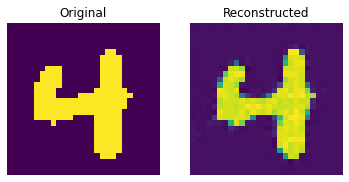

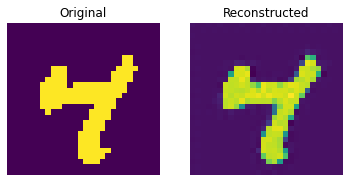

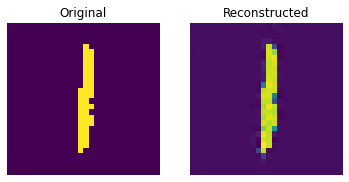

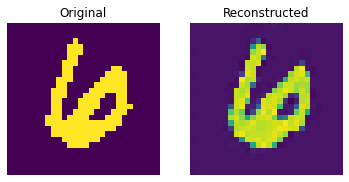

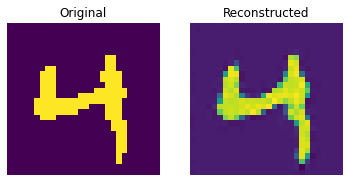

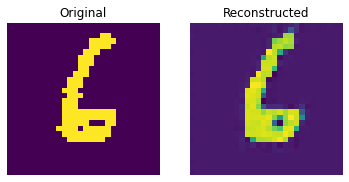

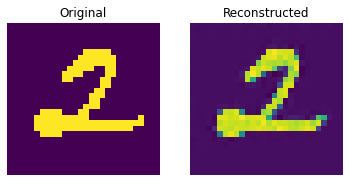

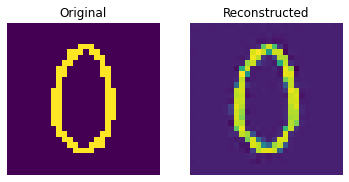

In [47]:
np_iter = test_dataset.as_numpy_iterator()
for it in np_iter:
    test_images = (it[:8])
    recon_images = vqvae_trainer.vqvae.predict(test_images)
    for test_image, recon_image in zip(test_images, recon_images):
        show_subplot(test_image, recon_image)
    break

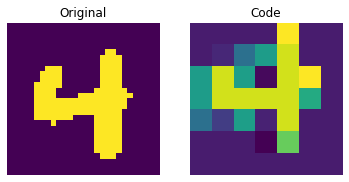

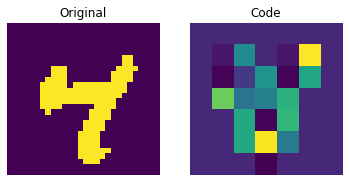

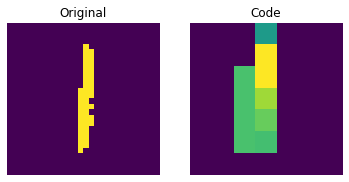

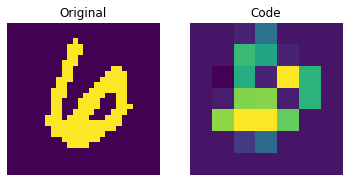

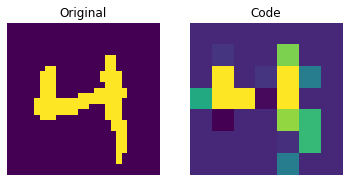

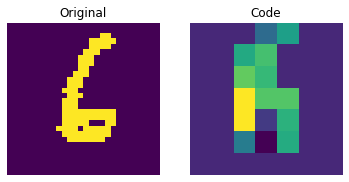

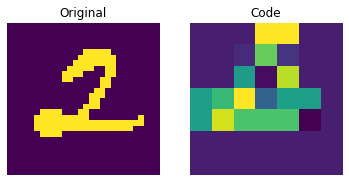

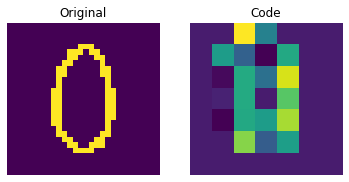

In [48]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()